In [75]:
from googleapiclient.discovery import build
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv


def get_video_comments(video_id, API_KEY, max_results=1000):
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    
    comments = []
    results = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        textFormat="plainText",
        maxResults=max_results
    ).execute()
    
    for item in results["items"]:
        comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
        comments.append(comment)
    
    return comments


In [76]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenización
    tokens = word_tokenize(text)
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [77]:
# Cargar datos
df = pd.read_csv('youtoxic_english_1000.csv')

# Preprocesar texto
df['processed_text'] = df['Text'].apply(preprocess_text)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['IsToxic'], test_size=0.2, random_state=42
)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

# Evaluar modelo
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.62      0.86      0.72        93
        True       0.82      0.54      0.65       107

    accuracy                           0.69       200
   macro avg       0.72      0.70      0.69       200
weighted avg       0.73      0.69      0.68       200



In [78]:
def classify_comments(comments, model, vectorizer):
    processed_comments = [preprocess_text(comment) for comment in comments]
    vectorized_comments = vectorizer.transform(processed_comments)
    predictions = model.predict(vectorized_comments)
    return predictions


In [80]:
def visualize_results(comments, predictions):
    toxic_count = sum(predictions)
    non_toxic_count = len(predictions) - toxic_count
    
    plt.figure(figsize=(10, 6))
    plt.bar(['No tóxico', 'Tóxico'], [non_toxic_count, toxic_count])
    plt.title('Clasificación de comentarios')
    plt.ylabel('Número de comentarios')
    plt.show()
    
    print(f"Comentarios tóxicos: {toxic_count}")
    print(f"Comentarios no tóxicos: {non_toxic_count}")
    
    print("\nEjemplos de comentarios tóxicos:")
    for comment, prediction in zip(comments, predictions):
        if prediction:
            print(f"- {comment[:1000]}...")


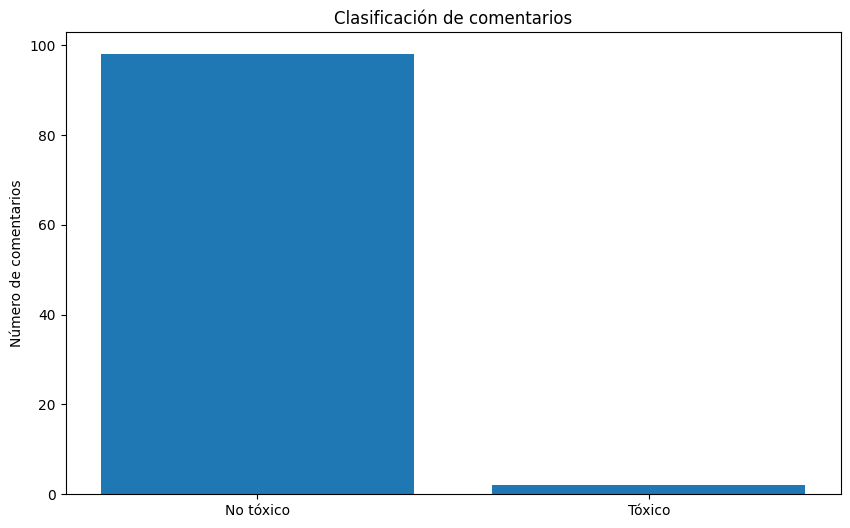

Comentarios tóxicos: 2
Comentarios no tóxicos: 98

Ejemplos de comentarios tóxicos:
- Bro.this was made 6 years before I was introduced to the world...
- October dumb. 🏴‍☠️...


In [81]:
load_dotenv()  # Carga las variables de entorno desde .env
API_KEY = os.getenv('API_KEY')
video_id = '4N1iwQxiHrs'

# Obtener comentarios
comments = get_video_comments(video_id, API_KEY)

# Clasificar comentarios
predictions = classify_comments(comments, model, vectorizer)

# Visualizar resultados
visualize_results(comments, predictions)
